### Imports

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sb
from pathlib import Path
import glob
import os
import scipy as sp

### To do:
1. Get velocity from acceleration (x,y,z)
2. get angle from angular velocity (x,y,z)
3. Get resultant velocity and angle

# Merge Original Data file into 1 CSV file

In [2]:
csv_files = glob.glob("camera_output/*/Data.csv")
all_dfs = []
for file_path in csv_files:
    source_folder = os.path.basename(os.path.dirname(file_path))
    df = pd.read_csv(file_path, header=0)
    df["source_folder"] = source_folder
    all_dfs.append(df)
    
merged_df = pd.concat(all_dfs, ignore_index=True)
merged_df.to_csv("merged_sensor_data.csv", index=False)

# Clean Merged Data file

In [3]:
import pandas as pd
from pathlib import Path

def clean_csv(file_path):
    df = pd.read_csv(file_path) # Read data into csv file
    
    cols_to_check = ['ax', 'ay', 'az', 'gx', 'gy', 'gz'] # Columns to check by label
    
# Step 1: Find bad recordings per source_folder
    invalid_recordings = (
        df.groupby(['source_folder', 'recording'])[cols_to_check]
        .apply(lambda g: (g.abs() >= 313).any().any())
    )

    # Get the (source_folder, recording) tuples to drop
    recordings_to_drop = invalid_recordings[invalid_recordings].index.tolist()

    # Step 2: Drop invalid recordings
    df_clean = df.copy()
    for source, rec in recordings_to_drop:
        df_clean = df_clean[~((df_clean['source_folder'] == source) & (df_clean['recording'] == rec))]

    # Re-label recordings within each source_folder
    df_clean = df_clean.copy()

    # for folder in df_clean['source_folder'].unique():
    #     mask = df_clean['source_folder'] == folder
    #     # unique_recordings = df_clean.loc[mask, 'recording'].unique()
    #     # new_labels = {old: new for new, old in enumerate(sorted(unique_recordings), start=1)}
    #     # df_clean.loc[mask, 'recording'] = df_clean.loc[mask, 'recording'].map(new_labels)


    # Step 4: Save cleaned file
    original_path = Path(file_path)
    new_file_path = original_path.with_name(original_path.stem + '_cleaned.csv')
    df_clean.to_csv(new_file_path, index=False)
    print(f"✅ Cleaned CSV saved to: {new_file_path}")

# Example usage:
clean_csv('merged_sensor_data.csv')

✅ Cleaned CSV saved to: merged_sensor_data_cleaned.csv


# Plotting Data

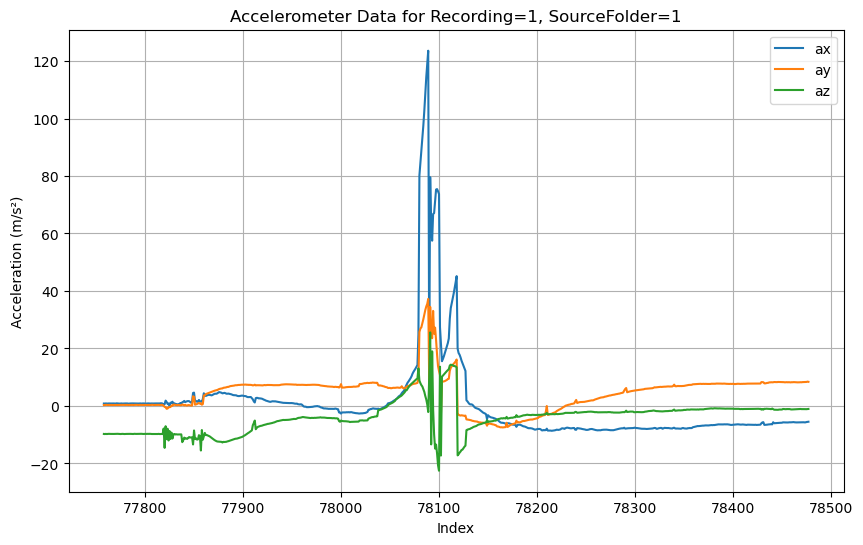

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned data
df = pd.read_csv('merged_sensor_data_cleaned.csv')
subset = df[(df["recording"] == 1) & (df["source_folder"] == 6)]

# Convert index to time in seconds
time_sec = df.index / 208  # 1000 samples = 1 second

# Columns for acceleration and gyroscope
accel_cols = ['ax', 'ay', 'az']
gyro_cols = ['gx', 'gy', 'gz']

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# # Plot acceleration data
# for col in accel_cols:
#     ax1.plot(time_sec, df[col], label=col)
# ax1.set_ylabel('Acceleration')
# ax1.set_title('Acceleration (ax, ay, az)')
# ax1.legend()
# ax1.grid(True)

# # Plot gyroscope data
# for col in gyro_cols:
#     ax2.plot(time_sec, df[col], label=col)
# ax2.set_ylabel('Gyroscope')
# ax2.set_xlabel('Time (seconds)')
# ax2.set_title('Gyroscope (gx, gy, gz)')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

# subset is your filtered DataFrame
plt.figure(figsize=(10, 6))

plt.plot(subset.index, subset["ax"], label="ax")
plt.plot(subset.index, subset["ay"], label="ay")
plt.plot(subset.index, subset["az"], label="az")

plt.xlabel("Index")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Data for Recording=1, SourceFolder=1")
plt.legend()
plt.grid(True)
plt.show()


# Calculate Velocities for each axis

In [ ]:
from scipy.integrate import cumulative_trapezoid

FS = 208.0 # Sampling Frequency
DT = 1.0 / FS # Time Difference between samples

def compute_velocity_final(group: pd.DataFrame) -> pd.Series:
    """
    Compute final velocities along x, y, z for one (recording, sourcefolder) group.
    Integration is done from the first row up to the row where az is maximum.
    Returns one row (pd.Series) with recording, sourcefolder, and final velocities.
    """
    # Keep only numeric values
    group = group.copy()
    ax = pd.to_numeric(group["ax"], errors='coerce')
    ay = pd.to_numeric(group["ay"], errors='coerce')
    az = pd.to_numeric(group["az"], errors='coerce')
    
    # Drop rows where any axis is NaN
    valid_idx = (~ax.isna()) & (~ay.isna()) & (~az.isna())
    group = group[valid_idx]
    ax = ax[valid_idx].to_numpy()
    ay = ay[valid_idx].to_numpy()
    az = az[valid_idx].to_numpy()

    # If group is empty after filtering, return NaNs
    if len(ax) == 0:
        return pd.Series({
            "recording": group["recording"].iloc[0] if len(group) > 0 else np.nan,
            "source_folder": group["source_folder"].iloc[0] if len(group) > 0 else np.nan,
            "velocity_x_final": np.nan,
            "velocity_y_final": np.nan,
            "velocity_z_final": np.nan
        })

    
    # Find index of max az
    pos_max_x = int(np.argmax(ax))
    pos_max_y = int(np.argmax(az))
    pos_max_z = int(np.argmax(ay))
    
    # start_index_x = pos_max_x - 100
    # start_index_y = pos_max_y - 100
    # start_index_z = pos_max_z - 100
    
    print(f"max pos X: {pos_max_x}")
    print(f"max pos Y: {pos_max_y}")
    print(f"max pos Z: {pos_max_z}")
    # Slice up to max az (use head for safety)
    ax_slice = ax[:pos_max_x+1]
    ay_slice = ay[:pos_max_y+1]
    az_slice = az[:pos_max_z+1]

    # Integrate using trapezoidal rule
    vx = cumulative_trapezoid(ax_slice, dx=DT, initial=0.0)[-1]
    vy = cumulative_trapezoid(ay_slice, dx=DT, initial=0.0)[-1]
    vz = cumulative_trapezoid(az_slice, dx=DT, initial=0.0)[-1]

    # Return one row as pd.Series
    return pd.Series({
        "recording": group["recording"].iloc[0],
        "source_folder": group["source_folder"].iloc[0],
        "velocity_x_final": vx,
        "velocity_y_final": vy,
        "velocity_z_final": vz
    })
    
df = pd.read_csv("merged_sensor_data_cleaned.csv")

velocities = (
    df.groupby(["recording", "source_folder"], group_keys=False)
    .apply(compute_velocity_final)
    .reset_index(drop=True)
)

print(velocities)